In [28]:
# importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored,cumulative_dynamic_auc, integrated_brier_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_classif
import sys
import scanpy as sc
import anndata
sys.path.append('../scripts')  

import plotting_utils as mplt
sys.path.append('../notebooks')  



In [29]:
# load processed dataframes
metadata_df = pd.read_csv('../data/cancer_metadata.csv', index_col=0)
expression = pd.read_csv('../data/cancer_tmm_log.csv', index_col=0)
metadata_df = metadata_df[metadata_df['os_time'] >=180]
expression = expression.loc[metadata_df.index]


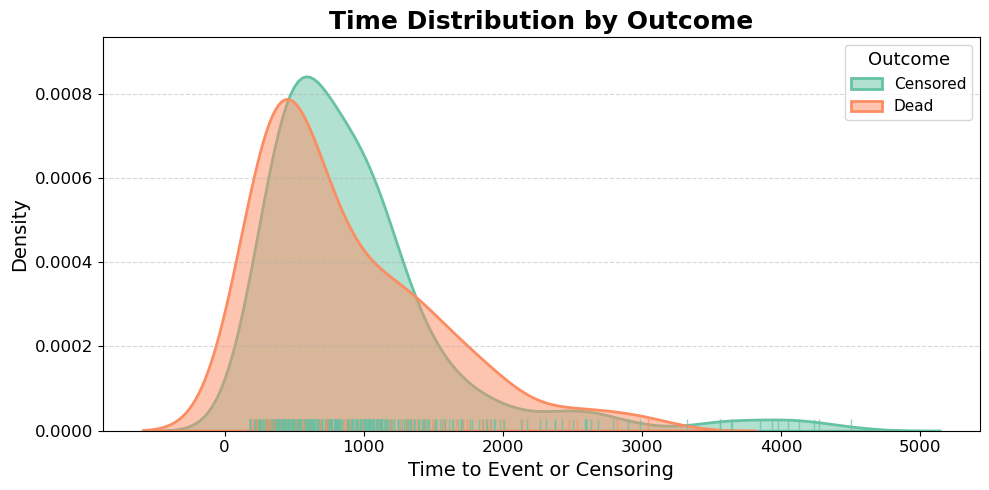

In [31]:
mplt.plot_time_distribution_by_outcome(metadata_df, time_col='os_time', status_col='os_status')

In [32]:
metadata_df['os_status'].value_counts()

os_status
Censored    445
Dead         92
Name: count, dtype: int64

In [ ]:
# splitting X and y and preparing right format for scikit survival 
metadata_df["os_status"] = metadata_df["os_status"].map({'Death':True,'Censored':False})

# Ensure os_time is float
metadata_df["os_time"] = metadata_df["os_time"].astype(float)

# Build survival array
y = np.array(
    list(zip(
        metadata_df["os_status"],
        metadata_df["os_time"]
    )),
    dtype=[('event', '?'), ('time', '<f8')]
)

metadata_df = metadata_df.drop(columns=['os_status','os_time','age_scaled'])

In [34]:
# Example: split metadata_df into train and test
train_df, test_df, y_train, y_test = train_test_split(expression, y,test_size=0.2, random_state=42,stratify=y['event'])

# selectin best features from expression
bestk = SelectKBest(score_func=f_classif, k=50)
bestk.fit(train_df,y_train)
X_train_selected = bestk.transform(train_df)
selected_feature_names = train_df.columns[bestk.get_support()]
# Transform and convert back to DataFrames
X_train_selected = pd.DataFrame(
    bestk.transform(train_df),
    columns=selected_feature_names,
    index=train_df.index
)

X_test_selected = pd.DataFrame(
    bestk.transform(test_df),
    columns=selected_feature_names,
    index=test_df.index
)
X_train = X_train_selected.merge(metadata_df, left_index=True, right_index=True)
X_test = X_test_selected.merge(metadata_df, left_index=True, right_index=True)

# Separate categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(include=['number']).columns

# ---- 1. Label Encoding ----
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()

    # Fit on train (ignoring NaNs)
    X_train[col] = X_train[col].astype(str).replace('nan', np.nan)
    not_null_mask_train = X_train[col].notnull()
    X_train.loc[not_null_mask_train, col] = le.fit_transform(X_train.loc[not_null_mask_train, col])

    # Transform test using the same encoder
    X_test[col] = X_test[col].astype(str).replace('nan', np.nan)
    not_null_mask_test = X_test[col].notnull()
    X_test.loc[not_null_mask_test, col] = le.transform(X_test.loc[not_null_mask_test, col])

    # Save encoder
    label_encoders[col] = le

# ---- 2. Scaling ----
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# ---- 3. Iterative Imputer (MICE) ----
mice_imputer = IterativeImputer()

X_train[categorical_cols] = mice_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = mice_imputer.transform(X_test[categorical_cols])

# Convert back to DataFrame
X_train = pd.DataFrame(X_train, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test, columns=X_test.columns, index=X_test.index)


In [ ]:
# # custom wrapper function for survival model tuning
def c_index_scorer(estimator, X,y):
    surv_pred = estimator.predict(X)
    result = concordance_index_censored(y['event'], y['time'], surv_pred)
    return result[0]

# define the random forest model
rsf = RandomSurvivalForest(random_state=42)

# 4. Define the parameter distribution
param_dist = {
    "n_estimators": [50,75,100,200,300],
    "max_depth": [2,3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "max_features": ["sqrt", "log2"]
}

# 5. Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rsf,
    param_distributions=param_dist,
    cv=3,
    scoring=c_index_scorer,
    random_state=42
)

# 6. Fit the model
random_search.fit(X_train, y_train)

# 7. View best params
print("Best Parameters:", random_search.best_params_)

# 8. Use the best model
best_rsf = random_search.best_estimator_
best_rsf.fit(X_train,y_train)
rsf_predict = best_rsf.predict(X_test)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}
Bestaccuracy on training data: 0.6940059514422332


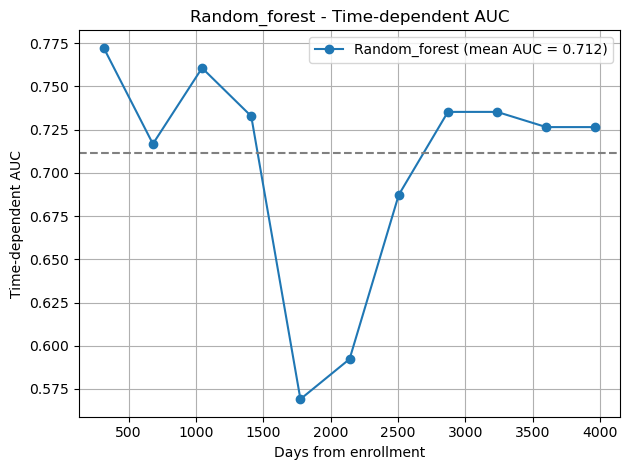

0.7115438830788937

In [36]:
os.makedirs("../results/cancer_survival", exist_ok=True)
# %% AUC Plotting function to be used later
def plot_auc(model_name, y_train, y_test, preds, intervals, output_dir):
    """
    Plot and save time-dependent AUC curve.
    """
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, preds, intervals)
    plt.figure()
    plt.plot(intervals, auc, marker="o", label=f"{model_name} (mean AUC = {mean_auc:.3f})")
    plt.axhline(mean_auc, linestyle="--", color='gray')
    plt.xlabel("Days from enrollment")
    plt.ylabel("Time-dependent AUC")
    plt.title(f"{model_name} - Time-dependent AUC")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{model_name}_auc_plot.png"))
    plt.show()
    plt.close()
    return mean_auc
#plot random forest AUC
y_min,y_max = np.min(y_test['time']), np.max(y_test['time'])
intervals = np.arange(y_min+100,y_max,365)
plot_auc("Random_forest",y_train,y_test,rsf_predict,intervals, "../results/cancer_survival")

In [37]:
# define the gradient boosting forest model
gbs = GradientBoostingSurvivalAnalysis(random_state=42)

# Define the parameter distribution
param_dist = {
    "n_estimators": [50,57,100,200],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2,3,5,7],
    "min_samples_leaf": [2,3,5],
    "learning_rate" : [0.01,0.1]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    gbs,
    param_distributions=param_dist,
    cv=5,
    scoring=c_index_scorer, 
    random_state=42,
)

# Fit the model
random_search.fit(X_train, y_train)

# View best params
print("Best Parameters:", random_search.best_params_)


# Use the best model
best_gbs = random_search.best_estimator_
best_gbs.fit(X_train, y_train)
gbs_predict = best_gbs.predict(X_test)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_depth': 3, 'learning_rate': 0.1}


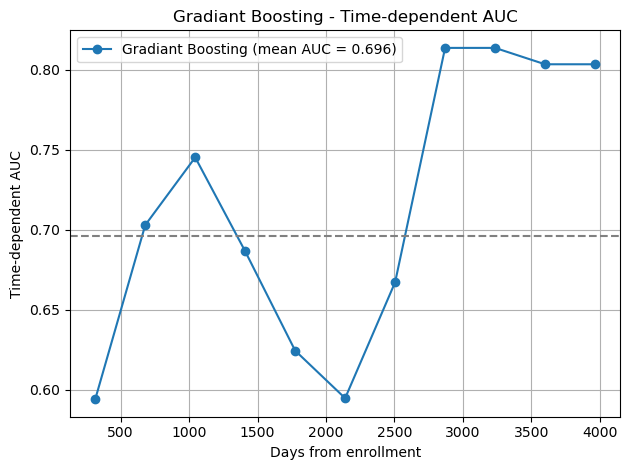

0.6963710227041284

In [38]:
# plot AUC
plot_auc('Gradiant Boosting',y_train,y_test,gbs_predict,intervals, "../results/cancer_survival")

In [39]:
# model evaluation with c index and brier score

rsf_surv_prob = np.vstack([fn(intervals) for fn in best_rsf.predict_survival_function(X_test)])
gbs_surv_prob = np.vstack([fn(intervals) for fn in best_gbs.predict_survival_function(X_test)])

score_cindex = pd.Series(
    [
        best_rsf.score(X_test, y_test),
        best_gbs.score(X_test, y_test),
    ],
    index=["RSF", "GBS"],
    name="c-index",
)
score_brier = pd.Series(
    [
        integrated_brier_score(y_train, y_test, prob, intervals)
        for prob in (rsf_surv_prob, gbs_surv_prob)
    ],
    index=["RSF", "GBS"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)


,c-index,IBS
RSF,0.712,0.174
GBS,0.703,0.174


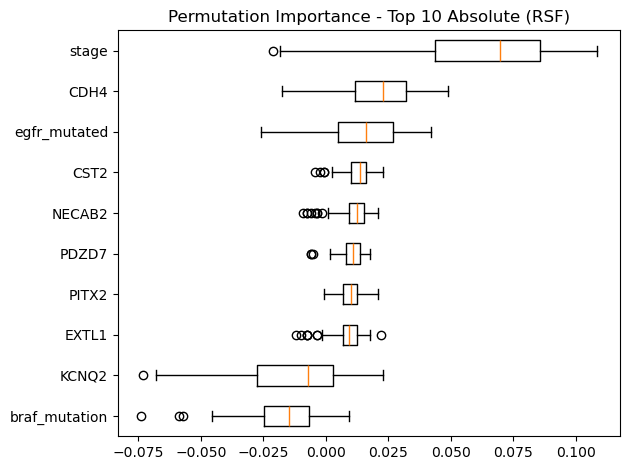

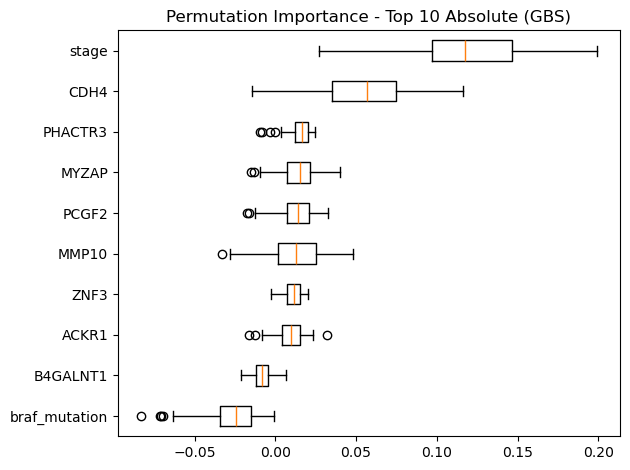

In [40]:
def plot_permutation_importance(model, X_test, y_test, model_name='Model', n_repeats=100, random_state=42):
    """
    Computes and plots permutation importance for a fitted model.
    Plots only the top 10 features by absolute importance,
    but displays their original (signed) importances.
    """
    result = permutation_importance(model, X_test, y_test,
                                     n_repeats=n_repeats,
                                     random_state=random_state)
    
    # Get indices for top 10 absolute importances
    abs_importances = np.abs(result.importances_mean)
    top10_idx = np.argsort(abs_importances)[-10:]
    
    # Sort top 10 by actual (signed) mean importance for nicer plot order
    top10_idx = top10_idx[np.argsort(result.importances_mean[top10_idx])]
    
    # Plot
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[top10_idx].T,
               vert=False,
               labels=X_test.columns[top10_idx])
    ax.set_title(f'Permutation Importance - Top 10 Absolute ({model_name})')
    fig.tight_layout()
    plt.show()

plot_permutation_importance(best_rsf, X_test, y_test, model_name='RSF')
plot_permutation_importance(best_gbs, X_test, y_test, model_name='GBS')
